# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are demarked into partitions to signify their specific task

In [2]:
from pathlib import Path

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from scipy.stats import friedmanchisquare

In [3]:
from lenskit import topn
from lenskit.metrics.predict import rmse

## Load Data

To begin the analysis, we first need to specify the dataset we would be working with, next we state the directory from which our recommendation and prediction files - which we had genertated from the prior section -  will be read from. 

In [4]:
dataset = "ml100k"

In [5]:
in_dir = Path("output")

In [6]:
dirs = [fld for fld in in_dir.glob(f'{dataset}-*')]

The following lines of code, loads the content of our recommendation and prediction files to a pandas dataframe data structure and extract the names of the algorithms we will be considering from the directory name. 

In [7]:
recs = []
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file, sep=',')
        rec["dataset"] = fld.name.split("-")[0]
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'dataset': 'category', 'algorithm': 'category'})

In [8]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file, sep=',')
        pred["dataset"] = fld.name.split("-")[0]
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)

In [9]:
testSplitData = "splitData"

In [10]:
SplitData_dir = Path(testSplitData)
dirs = [fld for fld in SplitData_dir.glob(dataset)]

In [11]:
test = []
for fld in dirs:
    for file in fld.glob("test-*"):
        test.append(pd.read_csv(file, sep=','))

test = pd.concat(test, ignore_index=True)

## Compute Metrics

In [12]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

nrecs  precision  recip_rank      ndcg
user dataset algorithm                                        
1    ml100k  ALS        100.0       0.00    0.000000  0.000000
             IALS       100.0       0.01    0.010526  0.051368
             II         100.0       0.01    0.016393  0.056903
             UU         100.0       0.00    0.000000  0.000000
2    ml100k  ALS        100.0       0.02    0.062500  0.129815

In [13]:
def summarize(vals):
    summary = sms.DescrStatsW(vals)
    lo, hi = summary.tconfint_mean()
    return pd.Series({'mean': np.mean(vals), 'lower': lo, 'higher': hi})

In [14]:
stats = results.drop(columns=['nrecs']).stack().groupby(level=['algorithm', -1]).apply(summarize)
stats

algorithm                    
ALS        precision   mean      0.010594
                       lower     0.009917
                       higher    0.011271
           recip_rank  mean      0.072280
                       lower     0.060951
                       higher    0.083610
           ndcg        mean      0.080681
                       lower     0.074329
                       higher    0.087034
IALS       precision   mean      0.033701
                       lower     0.032895
                       higher    0.034507
           recip_rank  mean      0.201434
                       lower     0.184915
                       higher    0.217952
           ndcg        mean      0.256107
                       lower     0.245898
                       higher    0.266317
II         precision   mean      0.009024
                       lower     0.008385
                       higher    0.009664
           recip_rank  mean      0.039078
                       lower     0.032363
    

In [15]:
pltData = (results.drop(columns=['nrecs']).stack()).reset_index().drop(columns=['dataset'])
pltData.columns = ['user', 'algorithm','metric', 'val']

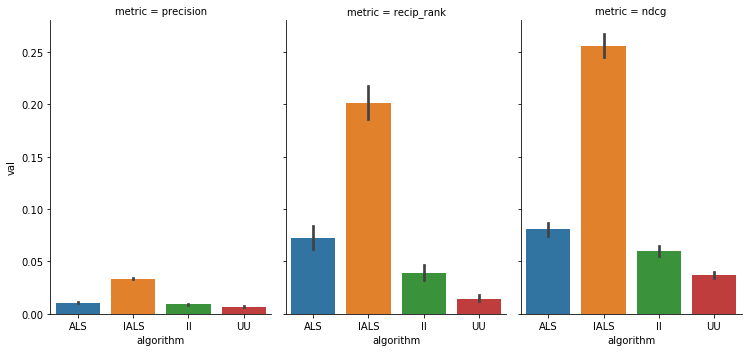

In [16]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=.7)

Which algorithm performed best? We need to perform significance testing on the results to ensure that the ranking of the algo based on the metric results are not by chance.

In [17]:
grp_data = results.drop(columns=['nrecs']).reset_index()

# ndcg   

#### Repeated Measures ANOVA

In [18]:
aovrm = AnovaRM(grp_data, 'ndcg', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                  Anova
          F Value  Num DF   Den DF  Pr > F
------------------------------------------
algorithm 998.7848 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [20]:
mc = MultiComparison(grp_data['ndcg'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   ALS   IALS   0.1754 0.001  0.1631  0.1877   True
   ALS     II  -0.0209 0.001 -0.0332 -0.0086   True
   ALS     UU  -0.0432 0.001 -0.0556 -0.0309   True
  IALS     II  -0.1963 0.001 -0.2086  -0.184   True
  IALS     UU  -0.2187 0.001  -0.231 -0.2064   True
    II     UU  -0.0223 0.001 -0.0346   -0.01   True
---------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [21]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["ndcg"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1471.867, p=0.000


#### Mixed Linear Model Regression

In [54]:
mixedlm = smf.mixedlm("ndcg ~ algorithm", grp_data, groups=grp_data["user"])
mixedlmf = mixedlm.fit()
print(mixedlmf.summary())

C:\Users\ngozi\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  msg = "The MLE may be on the boundary of the parameter space."


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  ndcg     
No. Observations:    3772     Method:              REML     
No. Groups:          943      Scale:               0.0094   
Min. group size:     4        Likelihood:          3208.4201
Max. group size:     4        Converged:           Yes      
Mean group size:     4.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.081    0.003 23.824 0.000  0.074  0.087
algorithm[T.IALS]  0.175    0.004 39.212 0.000  0.167  0.184
algorithm[T.II]   -0.021    0.004 -4.674 0.000 -0.030 -0.012
algorithm[T.UU]   -0.043    0.004 -9.666 0.000 -0.052 -0.034
Group Var          0.001    0.002                           



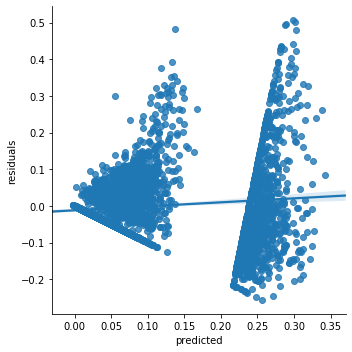

In [56]:
performance = pd.DataFrame()
performance["residuals"] = mixedlmf.resid.values
performance["ndcg"] = grp_data.ndcg
performance["predicted"] = mixedlmf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)


# precision   

#### Repeated Measures ANOVA

In [22]:
aovrm = AnovaRM(grp_data, 'precision', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                   Anova
           F Value  Num DF   Den DF  Pr > F
-------------------------------------------
algorithm 1932.4292 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [23]:
mc = MultiComparison(grp_data['precision'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ALS   IALS   0.0231  0.001  0.0219  0.0243   True
   ALS     II  -0.0016 0.0064 -0.0028 -0.0003   True
   ALS     UU  -0.0038  0.001 -0.0051 -0.0026   True
  IALS     II  -0.0247  0.001 -0.0259 -0.0234   True
  IALS     UU  -0.0269  0.001 -0.0282 -0.0257   True
    II     UU  -0.0023  0.001 -0.0035  -0.001   True
----------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [24]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["precision"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1802.031, p=0.000


# recip_rank

#### Repeated Measures ANOVA

In [25]:
aovrm = AnovaRM(grp_data, 'recip_rank', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                  Anova
          F Value  Num DF   Den DF  Pr > F
------------------------------------------
algorithm 245.0555 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [26]:
mc = MultiComparison(grp_data['recip_rank'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ALS   IALS   0.1292  0.001  0.1094  0.1489   True
   ALS     II  -0.0332  0.001 -0.0529 -0.0135   True
   ALS     UU  -0.0578  0.001 -0.0775 -0.0381   True
  IALS     II  -0.1624  0.001 -0.1821 -0.1426   True
  IALS     UU   -0.187  0.001 -0.2067 -0.1672   True
    II     UU  -0.0246 0.0074 -0.0443 -0.0049   True
----------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [27]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["recip_rank"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1147.249, p=0.000
